# Survey Validation Data Challenge - Summer 2019

### Notebook II: BGS GAMA field run.

The purpose of this notebook is to simulate DESI-like spectra of BGS targets bootstrapped from an input set of GAMA targets and redshifts, and then to run the spectra through the full DESI pipeline.
See  https://desi.lbl.gov/trac/wiki/BrightGalaxyWG/SVPlan

* Successful run on 18.12 up to spectro db production -- module swap fiberassign/1.0.0 required for assignment, which doesn't work beyond 18.12 (i.e. 19.2 and master).  Fiberassign dislikes sv_desi_target aswell.

* --survey sv1 is good for select_mock_targets.

* Stuck at 'rawdata' ready state in spectro database - preventing preproc and other dependencies running.

* Initial config. of desisurvey to point to sv tiles file; necessary for add_calibration exposures. 

* Got surveysim up and running by creating single pass, "LO" only groups in rules-sv.yaml

* Correct format for mock-targets.yaml?  E.g. list of contaminants / targets.  See also https://github.com/desihub/fiberassign/issues/198

* As per https://github.com/desihub/survey-validation/blob/master/sv-bgs-decals/main.py, set NUMOBS_MORE=4 in .mtl prior to assignment and specified calls to --nstarpetal 20  --nskypetal 80.

* See for truth.fits warnings:  /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/join_mock_targets.out

*  BGS target selection?  SV bits?  

*  ERROR:run_target_qa:37:<module>: The weightmap file was not passed so systematics cannot be tracked. 
   Try again sending --nosystematics.
    
*  Add Bright star mask and brick boundaries. 

In [1]:
import desitarget
import os
import sys
import pdb
import time
import pylab as pl
import subprocess
import glob
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
import fitsio
import astropy.io.fits   as fits

from   astropy.table     import Table

In [3]:
import seaborn as sns

sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))

notebook_start_time = time.time()

Starting at Tue May 14 21:35:03 2019


In [6]:
#- Some of these are imported just to establish versions
#- but aren't used in the notebook itself
import desisim
import desispec.io
from   desispec.scripts import pipe
import desitarget.io
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
from   surveysim.util import add_calibration_exposures
import desiutil.depend
import specter
import redrock
import simqso

from   desiutil import depend


##  Define versions: in flux. 
print(os.environ['DESIMODULES'])

deps = dict()

depend.add_dependencies(deps)
depend.setdep(deps, 'simqso', simqso.__version__)

for p in ('dust', 'desimodules'):
    if p.upper() + '_VERSION' in os.environ:
        depend.setdep(deps, p, os.environ[p.upper() + '_VERSION'])

for codename, version in depend.iterdep(deps):
    print('  {:12s} {}'.format(codename, version))

/global/common/software/desi/cori/desiconda/startup/modulefiles/desimodules
  python       3.6.6
  numpy        1.13.3
  scipy        1.1.0
  astropy      2.0.7
  yaml         3.12
  matplotlib   2.1.2
  fitsio       0.9.11
  healpy       1.11.0
  desiutil     1.9.15
  desispec     0.28.0
  desitarget   0.28.0
  desimodel    0.9.10
  desisim      0.31.2
  desisurvey   0.11.1
  specter      0.9.1
  speclite     0.8
  specsim      0.13
  surveysim    0.10.1
  redrock      0.14.0
  simqso       1.2.3
  dust         v0_1
  desimodules  19.2


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/0.28.0/lib/python3.6/site-packages/desitarget-0.28.0-py3.6.egg/desitarget/geomask.py:35: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/

## Define various directories and other io.

Define and create directories under `$DESI_ROOT/datachallenge/svdc-summer2018` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

In [7]:
if True:
    codedir = os.path.join(os.getenv('HOME'), 'desi', 'survey-validation', 'svdc-summer2018')

    #  Large file output. 
    basedir = os.path.join(os.getenv('SCRATCH'), 'svdc-summer2018')
    
else:
    codedir = os.path.join(os.getenv('DESI_PRODUCT_ROOT'), 'survey-validation', 'svdc-summer2018')
    basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')

In [8]:
print(basedir)
print(codedir)

/global/cscratch1/sd/mjwilson/svdc-summer2018
/global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018


In [9]:
is_sv                            = ''  ## ['sv-']

surveydir                        = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'surveysim2017', 'depth_0m')  
targetdir                        = os.path.join(basedir, is_sv + 'targets')
fibassigndir                     = os.path.join(basedir, is_sv + 'fiberassign')

os.environ['DESISURVEY_OUTPUT']  = surveydir

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', is_sv + 'redux')
os.environ['DESI_SPECTRO_SIM']   = os.path.join(basedir, 'spectro', is_sv + 'sim')

os.environ['PIXPROD']            = 'bgs-gama'
os.environ['SPECPROD']           = 'bgs-gama'

reduxdir                         = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir                       = os.path.join(os.environ['DESI_SPECTRO_SIM'],   os.environ['PIXPROD'])

os.environ['DESI_SPECTRO_DATA']  = simdatadir

for dd in (surveydir, targetdir, fibassigndir, reduxdir, simdatadir):
    os.makedirs(dd, exist_ok=True)

In [10]:
samplefile                       = os.path.join(basedir, 'bgs-gama-sample.fits')
surveyconfigfile                 = os.path.join(codedir, 'survey-config.yaml')
surveyrulesfile                  = os.path.join(codedir, 'rules.yaml')

##  Generated by cell 43; overwrite of Dawson tiles to Dark and Bright (program / conditions).
tilesfile                        = os.path.join(basedir, 'tiles', 'bgs-gama-tiles-bright.fits')

#### Specify the random seed for reproducibility of the survey simulations.

In [11]:
##  Required for surveysim calls (propagates to desisurvey.tiles, see this for further info.).
config                 = desisurvey.config.Configuration()                                                                                                                                       
config.tiles_file.set_value(tilesfile)

In [30]:
seed                   =   123

In [30]:
nside_mock_targets     =   64

#### Specify which steps should be redone (only used if the output files already exist).

If any of the following arguments are *True* then all the associated output files and plots will be recreated.  Warning: many of these steps are time-consuming (especially the mock spectra portion of the pipeline).

In [25]:
overwrite_tiles        =   True
overwrite_surveysim    =   True
overwrite_mock_spectra =   True
overwrite_join_spectra =   True
overwrite_fiberassign  =   True
overwrite_simspec      =   True

## Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [20]:
def read_gama_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
        
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
        
    return gama

In [21]:
gama = read_gama_sample()
gama

Read 132487 objects from /global/cscratch1/sd/mjwilson/svdc-summer2018/bgs-gama-sample.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,D4000N,HB_EW,HA_EW,FIELD,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_U,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_I,FIBERFLUX_Z,FIBERFLUX_Y,FIBERTOTFLUX_U,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_I,FIBERTOTFLUX_Z,FIBERTOTFLUX_Y,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,float32,float32,float32,bytes9,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,1.81131,5.20334,27.8028,G12,7000,335384,1741p007,1909,EXP,174.005987533,0.72094157246,7.40685e+12,4.4597e+12,475690.0 .. 615579.0,0.0223431,0.0,22.1154,36.5512,0.0,50.9447,0.0,35.6419,23.8391,34.8189,17.7839,0.0,385.058,266.155,0.0,27.5049,0.0,2.46397,0.472394

## Visualize the tiling of the G02, G09, G12, and G15 GAMA fields.

Here, we use a tiling solution generated by Kyle Dawson but we change the program name to DARK and set OBSCONDITIONS to zero (=DARK) until the appropriate hooks can be added to *desisurvey*.

In [27]:
def dawson2dark_tiles():
    """
    Ad hoc changes to the nominal tile file so we can get desisurvey running.
    """
    dawsonfile = os.path.join(basedir, 'tiles', 'bgs-gama-tiles-kdawson.fits')

    if os.path.isfile(dawsonfile):
        '''
        PROGRAM:  'BGS_SV', 
        
        'OBSCONDITIONS':  
        4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4,
        1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4,
        4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1,
        4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4,
        1, 4]
        
        tiles.pass_program

        {0: 'DARK',
         1: 'DARK',
         2: 'DARK',
         3: 'DARK',
         4: 'GRAY',
         5: 'BRIGHT',
         6: 'BRIGHT',
         7: 'BRIGHT'} 
        '''

        tiles = Table(fitsio.read(dawsonfile, ext=1))
        
        print('Updating PROGRAM and OBSCONDITIONS in {}'.format(dawsonfile))
        
        ##  Normal Bright program. 
        tiles['PASS']          =       5
        tiles['PROGRAM']       = 'BRIGHT'
        tiles['OBSCONDITIONS'] =       4
        
        brightfile = basedir + '/tiles/bgs-gama-tiles-bright.fits'
        
        print('Writing {}'.format(brightfile))
        
        tiles.write(brightfile, overwrite=True)


        ##  Normal Dark program.
        tiles['PASS']          = 1
        tiles['PROGRAM']       = 'DARK'
        tiles['OBSCONDITIONS'] = 0
        
        darkfile = basedir + '/tiles/bgs-gama-tiles-dark.fits'
        
        print('Writing {}'.format(darkfile))
        
        tiles.write(darkfile, overwrite=True)
    
    else:
        print('Dawson tiles file {} not found!'.format(dawsonfile))

In [23]:
def plot_tile(ra, dec, r=1.606, color='k', ax=None):
    '''
    Approximate plot of tile location
    '''
    ang = np.linspace(0, 2*np.pi, 100)
    x   = ra  + r*np.cos(ang)/np.cos(np.radians(dec))
    y   = dec + r*np.sin(ang)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x,y, '-', color=color, alpha=0.5)

In [23]:
def read_gama_tiles(overwrite=False):
    """
    Read the tiles file.
    """
    
    if overwrite:
        dawson2dark_tiles()
    
    if os.path.isfile(tilesfile):
        tiles = Table(fitsio.read(tilesfile, ext=1))
        
        print('Read {} tiles from {}'.format(len(tiles), tilesfile))
        
    else:
        print('Tiles file {} not found!'.format(tilesfile))
        
        tiles = []
    
    return tiles

In [19]:
def qa_gama_tiles(gama=None, tiles=None, gamafield=None, overwrite=False):
    if gama is None:
        gama  = read_gama_sample()

    if tiles is None:
        tiles = read_gama_tiles()

    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax      =  ax.reshape(4)
    
    for thisax, field in zip(ax, sorted(set(gama['FIELD']))):
        infield = gama['FIELD'] == field
    
        if np.count_nonzero(infield) > 0:
            thisax.scatter(gama['RA'][infield], gama['DEC'][infield], 
                           s=1, alpha=0.5, marker='s')
        
            ww = ( (tiles['RA'] > gama['RA'][infield].min()) * (tiles['RA'] < gama['RA'][infield].max()) * 
                   (tiles['DEC'] > gama['DEC'][infield].min()) * (tiles['DEC'] < gama['DEC'][infield].max()) )
            
            ## tiles[ww].write(basedir + '/tiles/bgs-gama-tiles-%s.fits' % field, overwrite=True)
            
            for tt in tiles[ww]:
                plot_tile(tt['RA'], tt['DEC'], ax=thisax)
            
        thisax.set_xlabel('RA')
        thisax.set_ylabel('Dec')
        
        thisax.invert_xaxis()
        
        thisax.set_title(field)
    
    fig.tight_layout()
    
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [28]:
tiles = read_gama_tiles(overwrite=overwrite_tiles)
tiles

Updating PROGRAM and OBSCONDITIONS in /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-kdawson.fits
Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-bright.fits
Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-dark.fits
Read 94 tiles from /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-bright.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,bytes6,int32
100000,212.399993896,-0.819999992847,5,1,0.0504712,1.0,1.0,1.0,BRIGHT,4
100001,213.199996948,-0.800000011921,5,1,0.0498524,1.0,1.0,1.0,BRIGHT,4
100002,214.0,-0.77999997139,5,1,0.049985,1.0,1.0,1.0,BRIGHT,4
100003,214.799987793,-0.759999990463,5,1,0.0459586,1.0,1.0,1.0,BRIGHT,4
100004,215.599990845,-0.819999992847,5,1,0.0451689,1.0,1.0,1.0,BRIGHT,4
100005,216.399993896,-0.800000011921,5,1,0.042806,1.0,1.0,1.0,BRIGHT,4
100006,217.199996948,-0.77999997139,5,1,0.0435473,1.0,1.0,1.0,BRIGHT,4
100007,218.0,-0.759999990463,5,1,0.042242,1.0,1.0,1.0,BRIGHT,4
100008,218.799987793,-0.819999992847,5,1,0.042335,1.0,1.0,1.0,BRIGHT,4


Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/qaplots/qa-gama-tiles.png


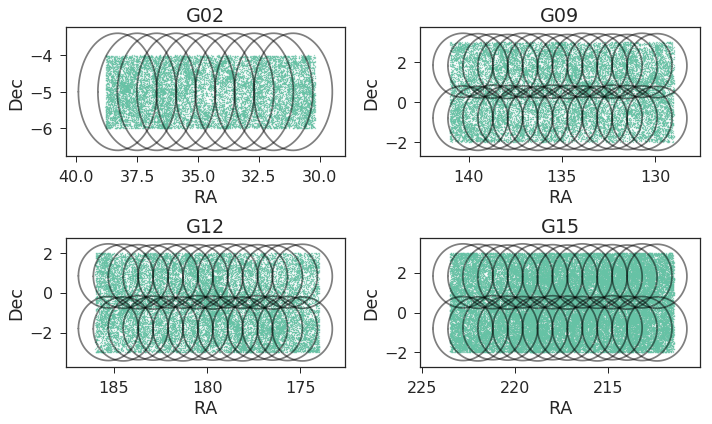

In [27]:
qa_gama_tiles(gama, tiles, overwrite=overwrite_tiles)

In [28]:
#  Write bgs-gama tile IDs to .txt for fiberassign --surveytiles. 
fname = tilesfile.split('.')[0] + '.txt'

print('Writing %s.' % fname)

np.savetxt(tilesfile.split('.')[0] + '.txt', tiles['TILEID'], fmt='%d')

Writing /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-bright.txt.


## Visualize the redshift distribution of the G02, G09, G12, and G15 GAMA fields.

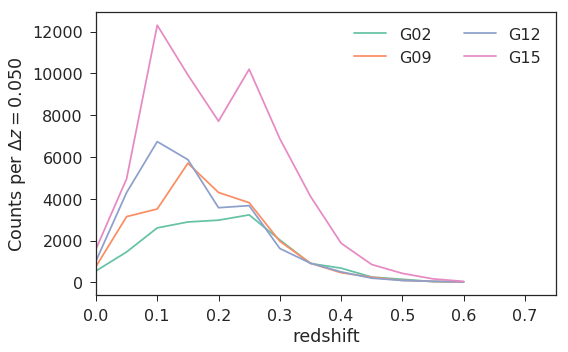

In [29]:
##  Plot GAMA redshift distribution. 
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

dz      = 0.05 
zbins   = np.arange(0.0, 0.7, dz)

for field in sorted(set(gama['FIELD'])):
    infield   = gama['FIELD'] == field
    counts, _ = np.histogram(gama['Z'][infield], bins=zbins)
    
    pl.plot(zbins[:-1], counts, label=field)
    
ax.set_xlim(0.0, 0.75)

ax.set_xlabel('redshift')
ax.set_ylabel(r'Counts per $\Delta z = %.3lf$' % dz)

ax.legend(ncol=2)    

fig.tight_layout()

## Run survey simulations (successful!  requires rules-sv.yaml)

The code below enables one to simulate SV observations of the GAMA fields using *desisurvey*:  This provides exposure times etc. 
However, since the dates of SV are still uncertain (and three of the four GAMA fields are spring or late-fall fields), we have opted to simulate observing conditions by simply drawing from the full-survey simulations.

In [80]:
import shutil


##  Change output_path in config file to e.g. /global/cscratch1/sd/mjwilson/svdc-summer2018/survey
configfile      = os.path.join(basedir + '/survey/desisurvey-config.yaml')

if os.path.exists(basedir + '/survey/surveyinit.fits'):
    print('surveyinit.fits already exists; skipping surveyinit')

else:
    logfilename = os.path.join(basedir + '/survey/surveyinit.log')
    cmd         = 'surveyinit --config-file {}'.format(configfile)

    print('Running {}'.format(cmd))
    
    print('Starting at {}; should take ~2 minutes'.format(time.asctime()))
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
    
        if err != 0:
            print('surveyinit failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        
        else:
            print('Done at {}'.format(time.asctime()))

surveyinit.fits already exists; skipping surveyinit


In [81]:
##  Error:  No tiles with priority > 0 available.
rulesfile         = os.path.join(basedir + '/survey/rules-sv.yaml')
surveysim_expfile = os.path.join(basedir + '/survey/exposures_surveysim.fits')

if os.path.exists(surveysim_expfile):
    print('Survey sims already done; skipping')

else:
    logfilename = os.path.join(basedir + '/survey/surveysim.log')

    cmd = 'surveysim --config-file {} --rules {} --save-restore'.format(configfile, rulesfile)
    
    print('Running {}'.format(cmd))
    
    print('Starting at {}; should take a few seconds'.format(time.asctime()))
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        
        if err != 0:
            print('surveysim failed err={}; see {}'.format(err, logfilename))
            
            raise RuntimeError
        
        else:
            print('done at {}'.format(time.asctime()))

Running surveysim --config-file /global/cscratch1/sd/mjwilson/svdc-summer2018/survey/desisurvey-config.yaml --rules /global/cscratch1/sd/mjwilson/svdc-summer2018/survey/rules-sv.yaml --save-restore
Starting at Tue May 14 21:19:37 2019; should take a few seconds
done at Tue May 14 21:19:41 2019


## Grab SV-like exposures (matching EBV and program) from 2017 survey simulation

In [20]:
def sample_survey_simulations(tiles, overwrite=False, seed=None):
    '''
    Generate the exposures file by drawing from the 2017 full-survey simulations.
    '''
    import copy
    import desisurvey
    
    from   astropy.table import Column
    
    
    expfile = os.path.join(surveydir, 'exposures.fits')
    
    if overwrite or not os.path.isfile(expfile):        
        from astropy.table  import vstack
        from surveysim.util import add_calibration_exposures

        
        config       = desisurvey.config.Configuration()                                                                                                                                       
        config.tiles_file.set_value(tilesfile)
        
        rand         = np.random.RandomState(seed)
        
        simexpfile   = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'surveysim2017',   'depth_0m', 'exposures.fits')
        #simexpfile  = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018', 'survey',   'exposures.fits')
        #simexpfile  = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'surveysim2018',   'survey',   'exposures.fits')
        
        if not os.path.isfile(simexpfile):
            print('Exposures file {} not found!'.format(simexpfile))
            raise IOError

        exp = Table.read(simexpfile)

        print('Read {} parent exposures from {}'.format(len(exp), simexpfile))

        # flag CR splits.  CR split? 
        _, uniq = np.unique(exp['TILEID'].data, return_index=True)
        
        explist = []
        
        ##  Range of EBV for tiles:  0.0504712 0.0192004    
        for tt in tiles:
            # Find exposures with the correct PROGRAM and close in Galactic 
            # reddening and then choose one at random (with uniform probability).
            # If there is more than one exposure, take both (CR split).            
            ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                           (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.02) )[0]
            
            if np.count_nonzero(ww) == 0:
                ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                               (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.051) )[0]
                
                if np.count_nonzero(ww) == 0:
                    print('Insufficient comparable exposures!')
                    raise ValueError
                
            # choose one at random.
            this = rand.choice(ww)
            
            # bring back CR splits.
            these = exp['TILEID'] == exp['TILEID'][uniq][this]
            
            _explist = vstack(exp[these])
            
            # Replace exposure data with criteria for Kyle's tiles.
            _explist['TILEID'] = tt['TILEID']
            _explist['PASS']   = tt['PASS']
            _explist['EBMV']   = tt['EBV_MED']
            _explist['RA']     = tt['RA']
            _explist['DEC']    = tt['DEC']
            
            explist.append(_explist)

        explist                = vstack(explist)
        
        # Assign all 94 tiles to a single (wonderful) NIGHT and MJD.
        this                   = np.where(exp['NIGHT'].data == '20191201')[0][0]
        explist['NIGHT'][:]    = exp['NIGHT'][this]
        explist['MJD'][:]      = exp['MJD'][this]
        
        # Add monotonically increasing epsilon perturbation to MJD to beat diff(MJD) > 0 catch in surveysim/util.py  
        epsilons               = 1.e-1 * np.sort(np.random.uniform(0., 1., len(explist['MJD'])))
        explist['MJD']        += epsilons
        
        '''
        Deprecated:  instead set desisurvey config.  See desisurvey.tiles
        
        # Save tile ID hack for add_calibration_exposures. 
        _keepTileIDs           = copy.copy(explist['TILEID'].quantity)

        # Rewrite tile IDs to nominal desi for add_calibration_exposures error. 
        desi_tileIDs           = desisurvey.tiles.get_tiles()
        
        explist['TILEID']      = desi_tileIDs.tileID[:len(explist['TILEID'])]
        '''     
        explist                = add_calibration_exposures(explist, flats_per_night=1, arcs_per_night=1)

        # Rewrite nominal desi tile program to bright. 
        explist['PROGRAM'][2:] = 'BRIGHT'
        
        # Reset TileIDs.
        '''
        Deprecated:  instead set desisurvey config.  See desisurvey.tiles
        explist['TILEID']  = Column(data=np.concatenate((np.array([-1, -1]), _keepTileIDs)), name='TILEID')
        '''

        # sequential IDs
        explist['EXPID']       = np.arange(len(explist))
        
    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [31]:
#%time explist = survey_simulations(tiles, overwrite=overwrite_surveysim)
%time explist  = sample_survey_simulations(tiles, overwrite=overwrite_surveysim, seed=seed)
explist

Read 26791 parent exposures from /global/project/projectdirs/desi/datachallenge/surveysim2017/depth_0m/exposures.fits
INFO:tiles.py:278:get_tiles: Initialized tiles from "/global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-bright.fits".
INFO:tiles.py:283:get_tiles: DARK   passes(tiles): .
INFO:tiles.py:283:get_tiles: GRAY   passes(tiles): .
INFO:tiles.py:283:get_tiles: BRIGHT passes(tiles): 5(94).
INFO:util.py:129:add_calibration_exposures: Added 1 nightly calibration sequences of 2 exposures each to 105 science exposures.
CPU times: user 550 ms, sys: 54.9 ms, total: 605 ms
Wall time: 667 ms


EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
int64,int32,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str6,str7
0,-1,0,0.0,0.0,0.0,20191201,58819.0581074,10.0,0.0,0.0,0.0,0.5,-10.0,90.0,CALIB,arc
1,-1,0,0.0,0.0,0.0,20191201,58819.0585704,10.0,0.0,0.0,0.0,0.5,-10.0,90.0,CALIB,flat
2,100000,5,212.399993896,-0.819999992847,0.0504712,20191201,58819.0590333,818.847484967,1.25228083134,0.996752858162,1.38296432707,0.839739249054,42.5812972125,89.7373323695,BRIGHT,science
3,100001,5,213.199996948,-0.800000011921,0.0498524,20191201,58819.0593388,712.542823234,1.39274728298,0.745773494244,1.20150185297,0.817615573679,39.2636793985,53.2857499896,BRIGHT,science
4,100001,5,213.199996948,-0.800000011921,0.0498524,20191201,58819.0603881,155.139523784,1.22972345352,0.947359859943,1.15730627826,0.817615573679,40.251728817,53.2031017155,BRIGHT,science
5,100002,5,214.0,-0.77999997139,0.049985,20191201,58819.0630464,567.632179509,1.29402196407,0.995585501194,1.01297518846,0.752980315014,20.9265020649,60.4143944288,BRIGHT,science
6,100003,5,214.799987793,-0.759999990463,0.0459586,20191201,58819.063143,491.90578498,0.88723474741,0.987792134285,1.04732190246,0.80270183232,11.6680262211,70.5048055037,BRIGHT,science
7,100004,5,215.599990845,-0.819999992847,0.0451689,20191201,58819.0635967,572.176215426,1.37980866432,0.988368451595,1.80643990605,0.823222410631,77.1686044045,60.8005530589,BRIGHT,science
8,100004,5,215.599990845,-0.819999992847,0.0451689,20191201,58819.0637341,707.609807499,1.37980866432,0.988368451595,1.80643990605,0.823222410631,77.1686044045,60.8005530589,BRIGHT,science


####  Alter BGS MOON PARAMETER dependence - hack around survey sim;  Stripped from minitest, but useful?

The default MOONALT, MOONSEP, and MOONFRAC columns are data model placeholders but not filled in with meaningful values. Correct that. 

Notes:
the code below is approximate (but still better than using MOONALT=-10 for BRIGHT exposures) surveysim doesn't currently vary the bright exposure time for lunar parameters (!), so filling this in with actual parameters instead of median defaults is arguably the wrong thing to do, but it does give us a variation of conditions from which one could calculate how the exposure times should vary.

In [36]:
import desisurvey.ephem
import warnings


warnings.filterwarnings('ignore', message=r'Tried to get polar motions for times after IERS data.')

def add_moon_params(explist):
    '''
    Fills MOONFRAC, MOONALT, MOONSEP columns in explist.
    '''    

    ephem_file = glob.glob(basedir + '/survey/ephem*.fits')[0]
    ephem      = Table.read(ephem_file)
    
    explist['MOONFRAC'] = np.interp(explist['MJD'], ephem['brightdusk'], ephem['moon_illum_frac'])

    ii = np.searchsorted(ephem['brightdusk'], explist['MJD'])-1

    assert np.all(ii>=0)
    
    for i, j in zip(ii, range(len(explist['MJD']))):
        if explist['FLAVOR'][j] != 'science':
            continue
        moon                  = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=True)
        mjd                   = explist['MJD'][j]
        explist['MOONALT'][j] = moon(mjd)[0]
        moon_dec, moon_ra     = desisurvey.ephem.get_object_interpolator(ephem[i], 'moon', altaz=False)(mjd)        
        phi1, phi2            = np.radians(moon_dec), np.radians(explist['DEC'][j])
        theta1, theta2        = np.radians(moon_ra), np.radians(explist['RA'][j])
        
        #- Haversine formula
        d                     = 2*np.arcsin(np.sqrt(np.sin(0.5*(phi2-phi1))**2 + np.cos(phi1)*np.cos(phi2)*np.sin(0.5*(theta2-theta1))**2))
        
        explist['MOONSEP'][j] = np.degrees(d)

In [34]:
##  add_moon_params(explist)

In [33]:
# Write exposure list. 
explist.write(basedir + '/survey/bgs-gama-exposures.fits', format='fits', overwrite='True')

#### Visualize which healpixels cover the observed tiles.

In [43]:
def plot_healpix(nside, pixels, ax=None):
    '''
    Plot healpix boundaries; doesn't work at RA wraparound.
    '''
    if ax is None:
        fig, ax    = plt.subplots()
        
    for p in pixels:
        xyz        = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta      = np.concatenate([theta, theta[0:1]])
        phi        = np.concatenate([phi, phi[0:1]])
        ra, dec    = np.degrees(phi), 90-np.degrees(theta)
        
        ax.plot(ra, dec, '.', color='0.6') 

In [47]:
def tiles2pixels(tiles, nside=64, fact=2**8):
    import desimodel.footprint
    
    
    pixels = desimodel.footprint.tiles2pix(nside, tiles, fact=fact)
    nexp   = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))

    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(len(tiles), nexp, len(pixels), nside))

    return pixels

In [45]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray   = explist['PROGRAM'] == 'GRAY'
    isdark   = explist['PROGRAM'] == 'DARK'
    
    fig, ax  = plt.subplots(figsize=(12, 8))

    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='deepskyblue', ms=10, mew=2, label='Dark exposure', alpha=1.0)
    ax.plot(  tiles['RA'],           tiles['DEC'],         'o', ms=5, color='k', label='Requested tiles', alpha=0.5)
    
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=5, mew=2, label='bright')
    
    ax.legend(loc='upper left')

    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

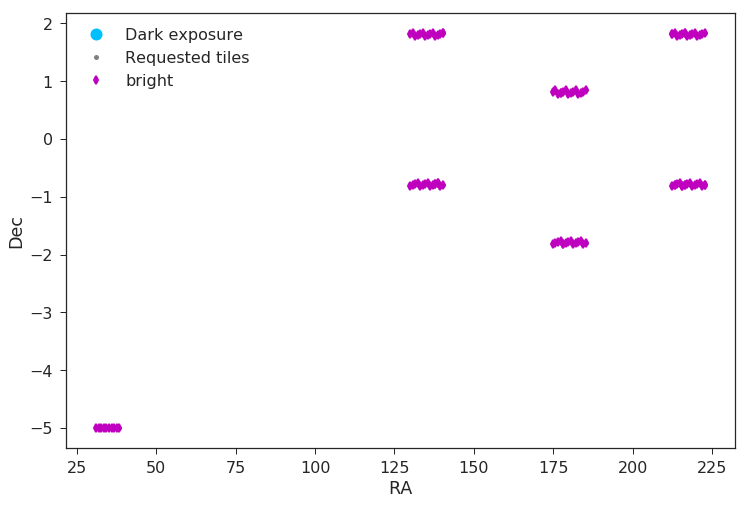

In [46]:
qa_observed_tiles()

In [47]:
def qa_tiles2pixels(tiles, nside=64, overwrite=False, plotit=False):
  pixels = tiles2pixels(tiles, nside=nside)
  
  if plotit:
    ##  Get science rather than calibration exposures.
    sci    = explist['FLAVOR'] == 'science'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    ax1.scatter(tiles['RA'], tiles['DEC'], marker='s', edgecolor='k', facecolor='none', lw=2, label='Tile Centers')
    ax1.scatter(explist['RA'][sci], explist['DEC'][sci], marker='o', alpha=0.7, label='Science exposures', s=6)
    
    ax1.legend(loc='upper left', markerscale=1.5)

    ax1.invert_xaxis()
    ax1.set_ylim(-7.5, 7.5)
    
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')

    plot_healpix(nside, pixels, ax=ax2)
    
    color = dict(DARK='m', GRAY='b', BRIGHT='m')
    
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = (tiles['PROGRAM'] == program)
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=1.)
        jj = tiles['PROGRAM'] == program

        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program], ax=ax2)
            
    xlim = ax2.get_xlim()
    
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
      
    fig.tight_layout()
    
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles-healpixels.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)        
    
    return pixels

In [48]:
pixels = qa_tiles2pixels(tiles, nside=nside_mock_targets, overwrite=overwrite_tiles)
pixels

94 tiles covered by 105 exposures and 416 nside=64 healpixels




Program split:

PROGRAM
-------
 BRIGHT
  CALIB
[105   2]





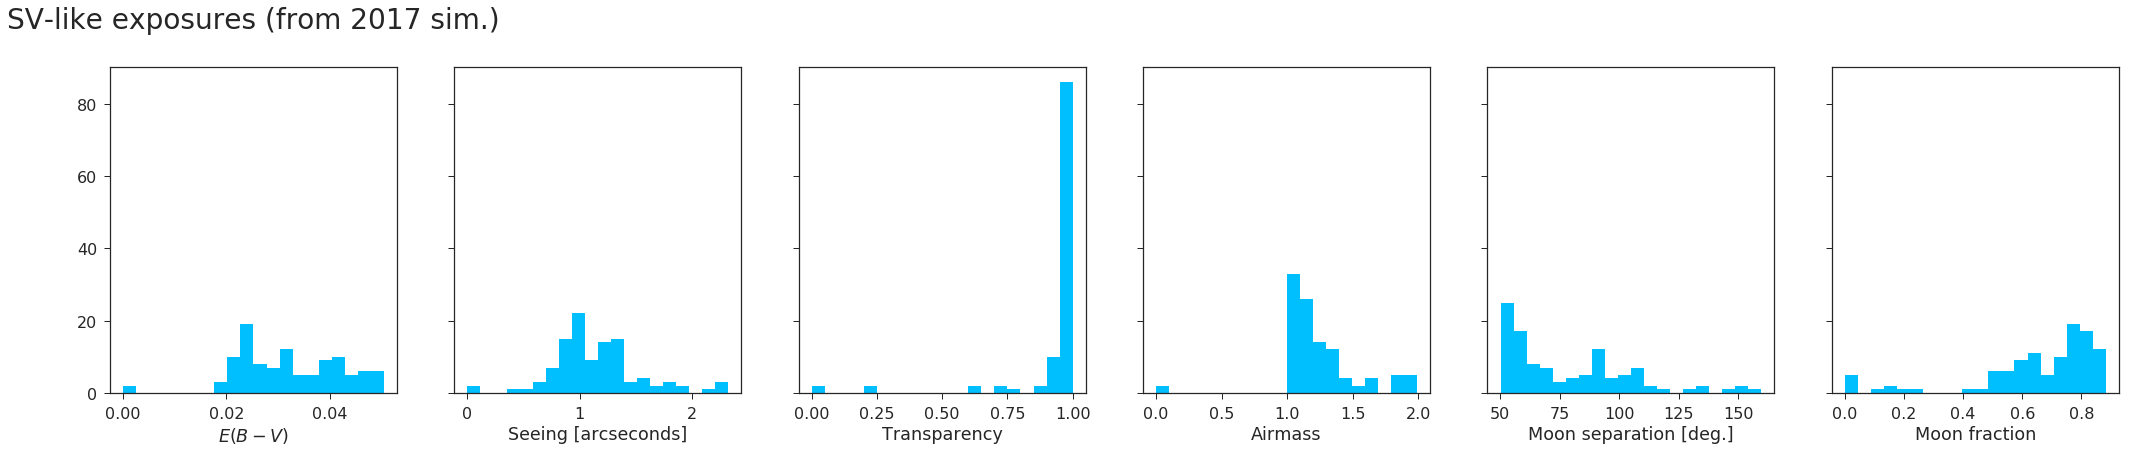

In [49]:
#  Plot up histograms of EXPTIME, SEEING, TRANSPARENCY, AIRMASS, MOONSEP, MOONFRAC, MOONALT.
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(36, 6), sharey=True)

ax1.hist(explist['EBMV'], bins=20, color='deepskyblue')
ax1.set_xlabel(r'$E(B-V)$')

ax2.hist(explist['SEEING'], bins=20, color='deepskyblue')
ax2.set_xlabel(r'Seeing [arcseconds]')

ax3.hist(explist['TRANSPARENCY'], bins=20, color='deepskyblue')
ax3.set_xlabel(r'Transparency')

ax4.hist(explist['AIRMASS'], bins=20, color='deepskyblue')
ax4.set_xlabel(r'Airmass')

ax5.hist(explist['MOONSEP'], bins=20, color='deepskyblue')
ax5.set_xlabel(r'Moon separation [deg.]')

ax6.hist(explist['MOONFRAC'], bins=20, color='deepskyblue')
ax6.set_xlabel(r'Moon fraction')

ax1.set_title('SV-like exposures (from 2017 sim.)\n', fontsize=28)

## 
pexp, counts = np.unique(explist['PROGRAM'], return_counts=True)

print('\n\nProgram split:\n')
print(pexp)
print(counts)
print('\n\n')

Text(0,0.5,'Exposure [s]')

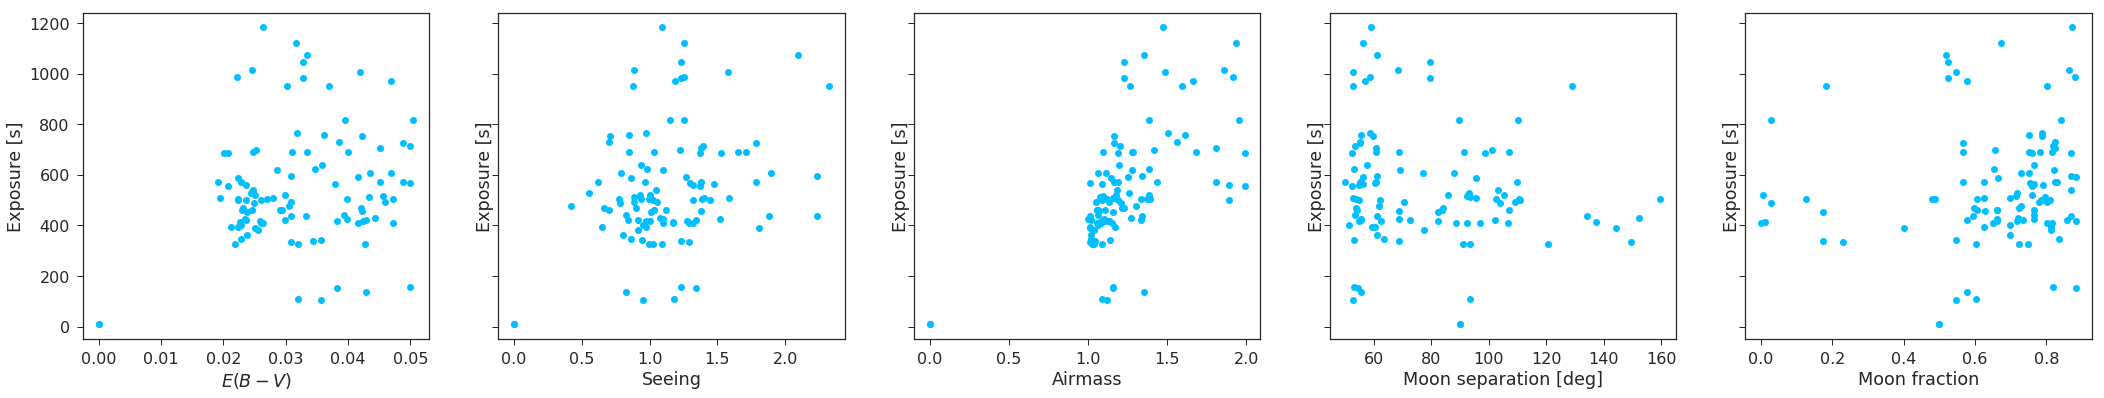

In [50]:
#  Plot EXPTIME vs SEEING, TRANSPARENCY, AIRMASS, MOONSEP, MOONFRAC, MOONALT.
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(36, 6), sharey=True)

ax1.plot(explist['EBMV'], explist['EXPTIME'], 'o', color='deepskyblue')
ax1.set_xlabel(r'$E(B-V)$')
ax1.set_ylabel(r'Exposure [s]')

ax2.plot(explist['SEEING'], explist['EXPTIME'], 'o', color='deepskyblue')
ax2.set_xlabel(r'Seeing')
ax2.set_ylabel(r'Exposure [s]')

ax3.plot(explist['AIRMASS'], explist['EXPTIME'], 'o', color='deepskyblue')
ax3.set_xlabel(r'Airmass')
ax3.set_ylabel(r'Exposure [s]')

ax4.plot(explist['MOONSEP'], explist['EXPTIME'], 'o', color='deepskyblue')
ax4.set_xlabel(r'Moon separation [deg]')
ax4.set_ylabel(r'Exposure [s]')

ax5.plot(explist['MOONFRAC'], explist['EXPTIME'], 'o', color='deepskyblue')
ax5.set_xlabel(r'Moon fraction')
ax5.set_ylabel(r'Exposure [s]')

## Simulate noiseless spectra using select_mock_targets.
Then, merge the target, sky, and stdstar catalogs and build the Merged Target List (MTL) file.

In [54]:
##  From here, process the minimal amount, e.g. one tile. 
fonetile    = basedir + '/tiles/bgs-gama-tiles-100000.fits'

onetile     = Table(fitsio.read(fonetile, ext=1))

##  Pixels for that one tile.
onetile_pix = tiles2pixels(onetile, nside=64)

print(onetile_pix)

1 tiles covered by 1 exposures and 21 nside=64 healpixels
[25912 25913 25914 25915 25916 25917 25918 25919 25962 26000 26001 26002
 26003 26004 26005 26006 26007 26012 26013 26048 26050]


In [14]:
def is_select_mock_targets_done(targetdir, pixels, verbose=True):
    done = True

    for filetype in ['targets', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))

        if len(filenames) != len(pixels):
            done = False
            
    return done

In [36]:
def select_mock_targets(tilesfile, nside=64, overwrite=False, verbose=False, mpi=True, no_spectra=False):
    """
    Run select_mock_targets.
    
    For debugging in an interactive node:
 
    #  Config mixes standards across both science and standards file.  Currently an issue for fiberassign/master. 
    salloc -N 15 -q interactive -L SCRATCH -C haswell -t 00:30:00 -n 30 -c 16

    #  Won't do anything if the healpix split directories already exist. 

    mpi_select_mock_targets 
       --output_dir /global/cscratch1/sd/mjwilson/svdc-summer2018/targets
       --config /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/mock-targets.yaml
       --seed 123 
       --nproc 16 
       --nside 64 
       --healpixels 25912 25913 25914 25915 25916 25917 25918 25919 25962 26000 26001 26002 26003 26004 26005 26006 26007 26012 26013 26048 26050
       --survey sv1       ##  [main, sv1] 
       
    Note:  See cell 36 for necessary pixel list.  E.g. pixels [21883] took 16.6 minutes.
    """
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    
    if overwrite or not is_select_mock_targets_done(tilesfile, nside=nside, verbose=verbose):
        print('Starting select_mock_targets at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))

        configfile = os.path.join(codedir, 'mock-targets.yaml')

        if mpi:
            cmd  = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:60:00 --qos interactive"
            cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
            cmd += " --seed {seed} --nproc 16 --nside {nside} --tiles {tilesfile} "
        
        else:
            cmd  = "select_mock_targets --output_dir {targetdir} --config {configfile}"
            cmd += " --seed {seed} --nproc 4 --nside {nside} --tiles {tilesfile} --overwrite "
        
        if no_spectra:
            cmd += "--no-spectra"
        
        cmd = cmd.format(targetdir=targetdir, tilesfile=tilesfile, 
                         configfile=configfile, seed=seed, nside=nside)
        
        print(cmd)
        
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
            
            if err != 0:
                print('select_mock_targets failed err={}; see {}'.format(err, logfilename))
                
            else:
                print('done at {}'.format(time.asctime()))
 
    else:
        print('All done with select_mock_targets; see log file {}'.format(logfilename))            

In [37]:
##  Pixels [21883] took 16.6 minutes; 21 nside=64 healpixels to be processed. 
##  
##  NOTE:  If output directories exist of given healpixel, no reprocessing will occur.  Delete first.  
select_mock_targets(fonetile, nside=nside_mock_targets, verbose=True, mpi=True, overwrite=overwrite_mock_spectra, no_spectra=True)

Starting select_mock_targets at Sat May 11 19:55:57 2019
Logging to /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/select_mock_targets.log
srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:60:00 --qos interactive mpi_select_mock_targets --output_dir /global/cscratch1/sd/mjwilson/svdc-summer2018/targets --config /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/mock-targets.yaml --seed 123 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-100000.fits --no-spectra
done at Sat May 11 19:56:08 2019


In [39]:
is_select_mock_targets_done(targetdir, onetile_pix, verbose=True)

21/21 targets files
21/21 truth files
21/21 sky files
21/21 standards-dark files
21/21 standards-bright files


True

In [40]:
def join_targets_truth_mtl(overwrite=False):
    mtlfile     = os.path.join(targetdir, 'mtl.fits')
    truthfile   = os.path.join(targetdir, 'truth.fits')
    targetsfile = os.path.join(targetdir, 'targets.fits')

    if (overwrite or not os.path.isfile(mtlfile) or not os.path.isfile(targetsfile) or not os.path.isfile(truthfile)):        
        cmd = "join_mock_targets --mockdir {} --overwrite".format(targetdir)
        
        print(cmd)
        
        err = subprocess.call(cmd.split())
        
        if err != 0:
            print('join_mock_targets failed err={}'.format(err))
        
        else:
            print('Successfully joined all targets and truth catalogs.')
        
    else:
        print('Using existing truth.fits {}'.format(truthfile))        
        print('Using existing targets.fits file {}'.format(targetsfile))        
        print('Using existing merged target list {}'.format(mtlfile))        

In [41]:
join_targets_truth_mtl(overwrite=overwrite_join_spectra)

join_mock_targets --mockdir /global/cscratch1/sd/mjwilson/svdc-summer2018/targets --overwrite
Successfully joined all targets and truth catalogs.


## Do basic sanity check on the result. 

Text(0.5,1,'Single G15 exposure.')

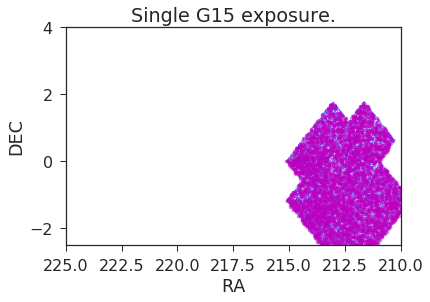

In [55]:
targets, target_hdr = fitsio.read(os.path.join(targetdir, 'targets.fits'), header=True)
truth               = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl                 = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std, std_hdr        = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'), header=True)
sky                 = fitsio.read(os.path.join(targetdir, 'sky.fits'))

pl.figure(figsize = (6,4))

pl.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
pl.plot(std['RA'], std['DEC'], 'm.', alpha=0.5)

pl.xlabel('RA')
pl.ylabel('DEC')

pl.xlim(225,  210)
pl.ylim(-2.5, 4.0)

pl.title('Single G15 exposure.')

## Run target selection QA
Successfully outputs to /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/qa

In [71]:
targetfile  = os.path.join(targetdir,   'targets.fits')
targetQAdir = os.path.join(targetdir,   'qa')
targetQAlog = os.path.join(targetQAdir, 'target-qa.log')

os.makedirs(targetQAdir, exist_ok=True)

# ERROR:run_target_qa:37:<module>: The weightmap file was not passed so systematics cannot be tracked. 
# Try again sending --nosystematics.
cmd = 'run_target_qa {} {} --mocks --nside 32 --nosystematics'.format(targetfile, targetQAdir)

print(cmd)

with open(targetQAlog, 'w') as logfile:
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

if err != 0:
    print('ERROR running {}'.format(cmd))

    msg = 'see {}'.format(targetQAlog)
    
    raise RuntimeError(msg)

run_target_qa /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/targets.fits /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/qa --mocks --nside 32 --nosystematics


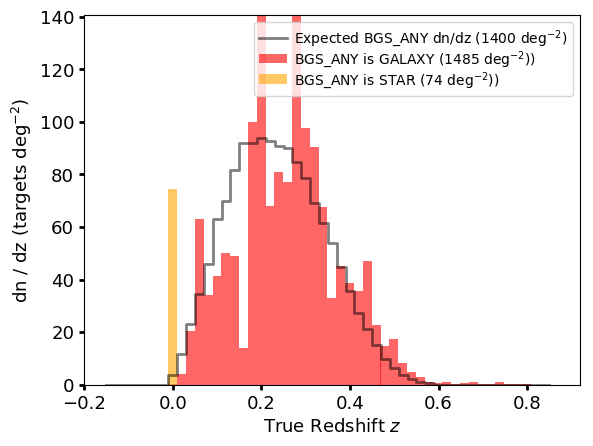

In [72]:
from IPython.display import Image, display

Image(targetQAdir + '/mock-nz-BGS_ANY.png',   width=8e2)

#### Rewrite NUMOBS_MORE in .mtl: 4 observations per target in SV. 

In [56]:
def set_sv_numobs(numobs=4):
  mtl = fits.open(targetdir + '/mtl.fits')

  mtl[1].data['NUMOBS_MORE'][mtl[1].data['NUMOBS_MORE'] > 0] = numobs

  mtl.writeto(targetdir + '/mtl.fits', overwrite=True)

  print('Successfully rewritten %s/mtl.fits to SV-like NUMOBS_MORE = 4.' % targetdir)

In [57]:
set_sv_numobs(1)

Successfully rewritten /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/mtl.fits to SV-like NUMOBS_MORE = 4.


## Fiber assignment

In [75]:
def is_fiberassign_done(tilesfile, verbose=False):
    """
    Check whether fiberassign successfully finished.
    """
    
    tiles = Table(fitsio.read(tilesfile, ext=1))
    done  = True
    
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'fiberassign_{:05d}.fits'.format(tileid))
        
        if not os.path.exists(tilefile):
            done = False
            
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

In [ ]:
def run_fiberassign(tilesfile, overwrite=False, verbose=False):
    '''
    To debug:  
    
    salloc -N 15 -q interactive -L SCRATCH -C haswell -t 00:30:00 -n 30 -c 16
    
    module swap fiberassign/1.0.0
    
    fiberassign  --mtl /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/mtl.fits 
                 --stdstar /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/standards-dark.fits 
                 --sky /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/sky.fits 
                 --surveytiles $HOME/desi/survey-validation/svdc-summer2018/bgs-gama-tiles-kdawson-100000.txt 
                 --footprint /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-100000.fits 
                 --fibstatusfile /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/fiberstatus.ecsv 
                 --outdir /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign 
                 --overwrite
                 
                 To be added:

                 --nstarpetal 20 
                 --nskypetal 80 
                 --overwrite
    '''
    
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')

    if overwrite or not is_fiberassign_done(tilesfile, verbose=verbose):
        print('Generating lists of dark and bright tiles')

        tiles = Table(fitsio.read(tilesfile, ext=1))

        bx, dx = None, None

        for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
            if program == 'BRIGHT':
                if bx is None:
                    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
                bx.write(str(tileid)+'\n')
                
            else:
                if dx is None:
                    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
                dx.write(str(tileid)+'\n')
                
        if bx:
            bx.close()
        
        if dx:
            dx.close()

        # Remove any leftover tile files
        for tilefile in glob.glob(fibassigndir + '/tile_*.fits'):
            os.remove(tilefile)

        cmd   = "fiberassign "
        cmd  += " --mtl {}/mtl.fits".format(targetdir)
        cmd  += " --stdstar {}/{{stdfile}}".format(targetdir)
        cmd  += " --sky {}/sky.fits".format(targetdir)
        cmd  += " --surveytiles {}/{{surveytiles}}".format(fibassigndir)
        cmd  += " --footprint {tilesfile}"
        #cmd += " --positioners {}/data/focalplane/fiberpos.fits".format(os.getenv('DESIMODEL'))
        cmd  += " --fibstatusfile {}/fiberstatus.ecsv".format(codedir)
        cmd  += " --outdir {}".format(fibassigndir)

        # Run fiberassign
        print('Logging to {}'.format(logfilename)); print()
        
        with open(logfilename, 'w') as logfile:
            for program in ['dark', 'bright']:
                stdfile     = 'standards-{}.fits'.format(program)
                surveytiles =      '{}-tiles.txt'.format(program)
        
                if os.path.isfile(os.path.join(fibassigndir, surveytiles)):
                    cmdx = cmd.format(stdfile=stdfile, surveytiles=surveytiles,
                                      tilesfile=tilesfile)
                    print(cmdx)
                
                    err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)

                    if err != 0:
                        print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
        if is_fiberassign_done(tilesfile, verbose=True):
            print('Success; Running QA.')
            print()

            !qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits
        
        else:
            print('ERROR: missing fiberassign output files')
        
    else:
        print('Finished fiber assignment; see log file {}'.format(logfilename))            

In [ ]:
#  Successfully run in shell  --  module swap fiberassign/1.0.0 required ... 
%time run_fiberassign(os.path.join(codedir, 'bgs-gama-tiles-%s.fits' % 'G02'), overwrite=overwrite_fiberassign)

###  Fiber assignment QA

In [ ]:
assignQAdir = os.path.join(basedir, 'fiberassign', 'qa')
assignQAlog = os.path.join(assignQAdir, 'assign-qa.log')

os.makedirs(assignQAdir, exist_ok=True)

cmd     = 'qa-fiberassign --verbose %s/fiberassign/tile-100000.fits --targets %s/targets.fits' % (basedir, targetdir)

print(cmd)

with open(assignQAlog, 'w') as logfile:
  err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

if err != 0:
  print('Fiberassign QA failed err={}; see {}'.format(err, assignQAlog))

### Combine surveysim, mocks, and fiberassign into simspec files.

[This step took roughly 27 minutes on my laptop with two tiles.]

In [52]:
def is_newexp_done(explist, verbose=False):    
    numnights     = len(set(explist['NIGHT']))
    nexp          = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles  = glob.glob(simdatadir + '/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir + '/*/fibermap*.fits')
    
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    
    elif len(fibermapfiles) != nexp:
        return False
    
    else:
        return True

In [ ]:
def run_newexp(tilefile, explist, overwrite=False, mpi=False, dryrun=False):
    '''
    Run newexp.

    Debug:
        
    salloc -N 15 -q interactive -L SCRATCH -C haswell -t 00:30:00 -n 15 -c 32

    srun -A desi -N 15 -n 15 -c 32 -C haswell -t 00:120:00 --qos debug 
    
    wrap-newexp 
         --fiberassign /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign 
         --mockdir /global/cscratch1/sd/mjwilson/svdc-summer2018/targets 
         --obslist /global/cscratch1/sd/mjwilson/svdc-summer2018/survey/bgs-gama-exposures.fits 
         --tilefile /global/cscratch1/sd/mjwilson/svdc-summer2018/tiles/bgs-gama-tiles-100000.fits  
         --outdir $SCRATCH/svdc-summer2018/spectro/sim/bgs-gama/ 
         --force
         --mpi
    
    Note this logs directly to projectdirs/user/
    e.g.  /global/project/projectdirs/desi/spectro/sim/mjwilson/20210421/00011517/simspec-00011517.log    

    Output:
    /global/project/projectdirs/desi/spectro/sim/mjwilson/20191201/00000000/simspec-00000000.log

    i.e.  Calibration written to 
    
    /global/project/projectdirs/desi/spectro/sim/mjwilson/20191201/
    

    Science written to outdir. 
    '''
    
    logfilename  = os.path.join(os.environ['SCRATCH'] + '/svdc-summer2018/spectro/sim/bgs-gama/' + 'newexp.log')
    #logfilename = os.path.join(simdatadir, 'newexp.log')
    
    if overwrite or not is_newexp_done(explist):
        logfilename = os.path.join(simdatadir, 'newexp.log')
        
        print('Logging to {}'.format(logfilename))

        cmd    = " wrap-newexp --fiberassign {}".format(fibassigndir)
        cmd   += " --mockdir {}".format(targetdir)
        cmd   += " --obslist {}/survey/bgs-gama-exposures.fits".format(basedir)
        cmd   += " --tilefile {}".format(tilefile)
        cmd   += " --outdir {}/spectro/sim/bgs-gama/".format(basedir)

        if dryrun:
          cmd += " --dryrun"
        
        if overwrite:
            cmd += " --force"
        
        print('Starting at {}'.format(time.asctime()))
        
        if 'NERSC_HOST' in os.environ:
            nodes      = 15
            nersc_cmd  = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
            nersc_cmd += " -C haswell -t 00:15:00 --qos interactive"
            cmd        = nersc_cmd + cmd 
            
        if mpi: 
            cmd       += ' --mpi'
        
        print(cmd)

        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            
            if err != 0:
                print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
                
            else:
                print('done')            
    else:
        print('newexp is done')
        
        is_newexp_done(explist, verbose=True)

In [ ]:
#  Single tile: 1 arc, 1 flat and 1 science exposure.
%time run_newexp(os.path.join(codedir, 'bgs-gama-tiles-%s.fits' % '100000'), explist, overwrite=overwrite_simspec, mpi=True)

# Single GAMA field.
# %time run_newexp(os.path.join(codedir, 'bgs-gama-tiles_%s.fits' % 'G02'), explist, overwrite=overwrite_simspec, mpi=True)

### Generate noisy uncalibrated spectra  using fastframe.

fastframe is a stripped down version of quickgen, and it uses specsim under the hood. 
specsim is memory hungry so we are limited to one process per node, leaving the other 
cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [ ]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat      = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience   = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe     = 30 * (nflat + nscience)
    
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')

    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return  False
    
    else:
        return  True

In [ ]:
def run_fastframe(overwrite=False):
    '''
    Debug:
     
    export SPECPROD='bgs-gama'
    export  PIXPROD='bgs-gama'
    
    export DESI_SPECTRO_SIM=/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/sim
    export DESI_SPECTRO_REDUX=/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux
    
    wrap-fastframe --mpi --outdir /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/fframe/bgs-gama/    


    Example dir. structure (hand created):
    
    /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/sim/bgs-gama/20191201/00000002/


    Note:  skips arcs, processes flats and science. 

    See: 
    
    https://github.com/desihub/desisim/blob/master/bin/wrap-fastframe
    https://desisim.readthedocs.io/en/latest/_modules/desisim/scripts/fastframe.html
    
    
    7.4 minutes for 0 arc, 1 flat, 1 science exposures;  Success!
    '''
    
    if is_fastframe_done(explist, reduxdir, verbose=True):
        print('fastframe already done; skipping')
        
    else:
        logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
        
        os.makedirs(os.path.dirname(logfilename), exist_ok=True)

        print('Running fastframe batch job; should take ~7 min.')
        print('Starting at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))
        
        nodes   = 15

        cmd     = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:120:00 --qos interactive".format(nodes=nodes)
        cmd    += " wrap-fastframe --mpi --clobber"

        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            
            if err != 0:
                print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
            
            else:
                print('Done at {}'.format(time.asctime()))

        if is_fastframe_done(explist, reduxdir, verbose=True):
            print('SUCCESS')
        
        else:
            print('ERROR; see {}'.format(logfilename))

In [ ]:
run_fastframe()

In [57]:
#- Check individual framefile outputs
ntot = 0
nbad = 0

for night, expid, flavor in explist['NIGHT', 'EXPID', 'FLAVOR']:
    if flavor != 'flat' and flavor != 'science':
        continue

    for channel in ['b', 'r', 'z']:
        for spectrograph in range(10):
            camera    = channel + str(spectrograph)
            framefile = desispec.io.findfile('frame', night, expid, camera)
            ntot     += 1
            
            if not os.path.exists(framefile):
                nbad += 1
                print('Missing {} frame {}'.format(flavor, framefile))

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))

else:
    print('All {} science and flat frame files generated'.format(ntot))

Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b0-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b1-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b2-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b3-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b4-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b5-00000001.fits
Missing flat frame /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/exposures/20191201/00000001/frame-b6-00000001.fits
Missing flat frame /global/

## Run the spectro pipeline
### First, create the production database.

In [101]:
print(os.getenv('DESI_SPECTRO_DATA'))
print(os.getenv('DESI_SPECTRO_REDUX'))
print(os.getenv('SPECPROD'))

/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/sim/bgs-gama
/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux
bgs-gama


In [102]:
from desispec.io import get_pipe_database


pipedbfile = get_pipe_database()

if not os.path.exists(pipedbfile):
    cmd = "desi_pipe create --db-postgres --force"
    cmd += " --data {}".format(os.getenv('DESI_SPECTRO_DATA'))
    cmd += " --redux {}".format(os.getenv('DESI_SPECTRO_REDUX'))
    cmd += " --prod {}".format(os.getenv('SPECPROD'))
    
    print(cmd)
    
    err = subprocess.call(cmd.split())
    
    assert err == 0
    
    ##  '/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/desi.db'
    assert os.path.exists(desispec.io.get_pipe_database())
    
    print('SUCCESS')
    
else:
    print('spectro pipeline DB file (%s) already exists; skipping' % pipedbfile)
    
##  Set environment variable for product. 
os.environ['DESI_SPECTRO_DB'] = os.getenv('DESI_SPECTRO_REDUX') + '/' + os.getenv('SPECPROD') + '/desi.db'

print('\n\nSet $DESI_SPECTRO_DB to:  ' + os.getenv('DESI_SPECTRO_DB'))

spectro pipeline DB file (/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/desi.db) already exists; skipping


Set $DESI_SPECTRO_DB to:  /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/desi.db


In [59]:
pipe_setup_file = desispec.io.specprod_root() + '/setup.sh'

with open(pipe_setup_file) as fx:
    for line in fx:
        line = line.strip()
        if line.startswith('export '):
            keyvalue = line.split(' ')[1]
            key, value = keyvalue.split('=', maxsplit=1)
            if key in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
                continue
            if key in os.environ and value != os.environ[key]:
                print('{} {} -> {}'.format(key, os.environ[key], value))
            elif key not in os.environ:
                print('Setting {}={}'.format(key, value))
            
            os.environ[key] = value

Setting DESI_CCD_CALIBRATION_DATA=/global/project/projectdirs/desi/spectro/ccd_calibration_data/trunk
Setting DESI_SPECTRO_DB=/global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/desi.db


### Sync up with the actual files on disk

We didn't start with raw data files, so we'll skip over extraction and PSF-fitting steps.
`desi_pipe sync` will update the database from what files are actually on disk.

In [50]:
err = subprocess.call('desi_pipe sync'.split())

assert err == 0

output = subprocess.check_output('desi_pipe top --once'.split())

print(output.decode())

----------------+---------+---------+---------+---------+---------+---------+
   Task Type    | waiting | ready   | running | done    | failed  | submit  |
----------------+---------+---------+---------+---------+---------+---------+
preproc         |        0|        0|        0|        0|        0|        0|
psf             |        0|        0|        0|        0|        0|        0|
psfnight        |        0|        0|        0|        0|        0|        0|
traceshift      |        0|        0|        0|        0|        0|        0|
extract         |        0|        0|        0|        0|        0|        0|
fiberflat       |        0|        0|        0|        0|        0|        0|
fiberflatnight  |        0|        0|        0|        0|        0|        0|
sky             |        0|        0|        0|        0|        0|        0|
starfit         |        0|        0|        0|        0|        0|        0|
fluxcalib       |        0|        0|        0|        0|       

## Notes
Preproc has fibermap and rawdata dependencies.  Currently, nothing happens as 
the state of rawdata is ready, rather than done. 

Cheap hack that would fix this:                                                                             cur.execute("UPDATE {tn} SET {cn}=3".format(tn='rawdata', cn='state'))

### Run pipeline scripts as a series of interactive jobs

`desi_pipe chain` would be a more convenient way of doing this,
but for the minitest it takes too long to wait for N>>1 jobs in the debug queue.


Ensure exposures are in:

DESI_SPECTRO_REDUX/SPECPROD/exposures/night/

as per get_exposures of 

https://github.com/desihub/desispec/blob/012070d7121a6c6c74ea51958667d49feb8bfa02/py/desispec/io/meta.py

In [104]:
from desispec.pipeline import load_db


taskdir   = os.path.join(desispec.io.get_pipe_rundir(), 'minitest')

os.makedirs(taskdir, exist_ok=True)

dbpath    = desispec.io.get_pipe_database()
db        = load_db(dbpath, mode="w")

tasktypes = ['fiberflat', 'fiberflatnight', 'sky', 'starfit', 'fluxcalib', 'cframe', 'spectra', 'redshift']


print('Loading database:  %s' % dbpath)

for tasktype in tasktypes:
    for night in np.unique(explist['NIGHT']):
        print('Getting ready for night: %s' % night)
        
        ##  /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desispec/0.27.0/lib/python3.6/site-packages/desispec-0.27.0-py3.6.egg/desispec/pipeline/db.py
        db.getready(night)

    taskfile = "{}/{}.tasks".format(taskdir, tasktype)

    cmd  = "desi_pipe tasks --tasktype {} --states ready,waiting ".format(tasktype)
    cmd += " > {}".format(taskfile)
    
    print('\n' + cmd)
    
    try:
        subprocess.check_call(cmd, shell=True)
    
    except subprocess.CalledProcessError:
        print('FAILED: {}'.format(cmd))
    
        break

    task_count = db.count_task_states(tasktype)

    print()
    print(task_count)

    if tasktype == 'redshift':
        ranks_per_task = 32
        cores_per_rank = 2
        n              = task_count['ready'] * ranks_per_task // 2  #- two iterations
        nodes          = (n-1) // 32 + 1
        runtime        = 59    #- minutes
    
    elif tasktype == 'spectra':
        ranks_per_task = 1
        cores_per_rank = 8
        n              = task_count['ready'] * ranks_per_task
        runtime        = 20    #- minutes
    
    else:
        ranks_per_task = 1
        cores_per_rank = 2
        n              = task_count['ready'] * ranks_per_task
        runtime        = 15    #- minutes

    nodes = (n*cores_per_rank-1) // 64 + 1

    if n > 0:
        t0 = time.time()

        cmd = 'srun -A desi -t {}:00 -C haswell --qos interactive'.format(runtime)
        cmd += ' -N {nodes} -n {procs} -c {cores} '.format(nodes=nodes, procs=n, cores=cores_per_rank)
        cmd += ' desi_pipe_exec_mpi --tasktype {} --taskfile {}'.format(tasktype, taskfile)
        
        logfilename = '{}/{}.log'.format(taskdir, tasktype)
        
        print('Running {} {} tasks'.format(n, tasktype))
        print('Logging to {}'.format(logfilename))
        print(cmd)
        
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        
            if err != 0:
                print('    ERROR {} for tasktype {}'.format(err, tasktype))
                print('    See {}'.format(logfilename))
            
            else:
                dt = time.time() - t0
                print('  DONE at {}'.format(time.asctime()))
                print('  {} took {:.1f} min'.format(tasktype, dt/60))
    
    elif task_count['waiting'] == 0 and task_count['done'] > 0:
        print('All {} tasks already run'.format(tasktype))
    
    else:
        print('No {} tasks ready to run; skipping'.format(tasktype))

for night in np.unique(explist['NIGHT']):
    db.getready(night)

print(subprocess.check_output('desi_pipe top --once'.split()).decode())

Loading database:  /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/desi.db
Getting ready for night: 20191201

desi_pipe tasks --tasktype fiberflat --states ready,waiting  > /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/run/minitest/fiberflat.tasks

OrderedDict([('waiting', 30), ('ready', 0), ('running', 0), ('done', 0), ('failed', 0)])
No fiberflat tasks ready to run; skipping
Getting ready for night: 20191201

desi_pipe tasks --tasktype fiberflatnight --states ready,waiting  > /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/run/minitest/fiberflatnight.tasks

OrderedDict([('waiting', 30), ('ready', 0), ('running', 0), ('done', 0), ('failed', 0)])
No fiberflatnight tasks ready to run; skipping
Getting ready for night: 20191201

desi_pipe tasks --tasktype sky --states ready,waiting  > /global/cscratch1/sd/mjwilson/svdc-summer2018/spectro/redux/bgs-gama/run/minitest/sky.tasks

OrderedDict([('waiting', 30), ('ready', 0), ('ru